In [1]:
def longestCommonPrefix(s1, s2):
    
    i = 0
    while i < len(s1) and i < len(s2) and s1[i] == s2[i]:
        i+=1
    return s1[:i]

In [2]:
longestCommonPrefix('ACCATGT', 'ACCAGAC')

'ACCA'

In [3]:
def match(s1, s2):
    
    if not len(s1) == len(s2):
        return False
    
    for i in range(len(s1)):
        if not s1[i] == s2[i]:
            return False
        
    return True

In [6]:
match('ACCCGTAT', 'ACCCGTAC')

False

In [9]:
complement = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}

In [15]:
def reverseComplement(s):
    
    complement = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    t = ''
    
    for base in s:
        t = complement[base] + t
    return t

In [17]:
reverseComplement('ACCGCGT')

'ACGCGGT'

In [22]:
def readGenome(filename):
    
    genome = ''
    
    with open(filename, 'r') as f:
        
        for line in f:
            if not line[0] == '>':
                genome += line.rstrip()
    
    return genome  

In [26]:
genome = readGenome('lambda_virus.fa')
len(genome)

48502

In [28]:
def countFrequency(genome):
    
    counts = {'A':0, 'T':0, 'C':0, 'G':0}
    
    for i in range(len(genome)):
        
        counts[genome[i]]+=1 
        
    return counts

In [31]:
import collections
collections.Counter(genome)

Counter({'A': 12334, 'C': 11362, 'G': 12820, 'T': 11986})

In [33]:
def readFastQ(filename):
    
    sequences = []
    qualities = []
    
    with open(filename, 'r') as f:
        
        while True:
            
            f.readline()
            seq = f.readline().rstrip()
            f.readline()
            qual = f.readline().rstrip()
            if len(seq) == 0:
                break
            else:
                sequences.append(seq)
                qualities.append(qual)
                
    return sequences, qualities

In [34]:
seqs, quals = readFastQ('SRR835775_1.first1000.fastq')

In [37]:
def phred33ToQ(qual):
    return ord(qual)-33

In [39]:
def createHist(qualities):
    
    hist = [0]*50
    for qual in qualities:
        for phred in qual:
            
            q = phred33ToQ(phred)
            hist[q]+=1
    return hist

In [41]:
h = createHist(quals)
print(h)

[0, 0, 6178, 0, 0, 54, 108, 574, 345, 83, 193, 124, 79, 165, 49, 236, 184, 327, 514, 238, 531, 254, 313, 798, 992, 888, 1396, 1488, 993, 1752, 3387, 4487, 3248, 5476, 8375, 11814, 4243, 7827, 6579, 8179, 9349, 8180, 0, 0, 0, 0, 0, 0, 0, 0]


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

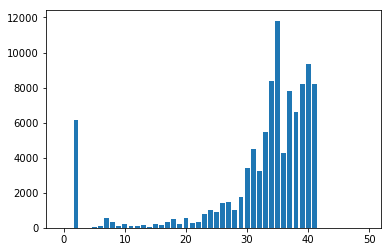

In [44]:
plt.bar(range(50), h)
plt.show()

In [48]:
def findGCByPos(reads):
    
    gc = [0]*len(reads[0])
    totals = [0]*len(reads[0])
    
    for read in reads:
        for i in range(len(read)):
            if read[i] == 'C' or read[i] == 'G':
                gc[i]+=1
            totals[i]+=1
            
    for i in range(len(gc)):
        if totals[i] > 0:
            gc[i] /= float(totals[i])
    
    return gc
    

In [49]:
gc = findGCByPos(seqs)

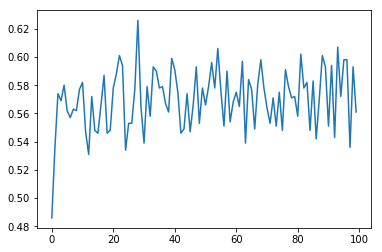

In [51]:
plt.plot(range(len(gc)), gc)
plt.show()

mean(gc)

In [52]:
import collections
count = collections.Counter()
for seq in seqs:
    count.update(seq)
print(count)

Counter({'G': 28742, 'C': 28272, 'T': 21836, 'A': 21132, 'N': 18})


In [53]:
genome = readGenome('phix.fa')

In [58]:
def naive(p, t):
    
    occurrences = []
    
    for i in range(len(t)-len(p) + 1):
        match = True
        
        for j in range(len(p)):
            
            if not t[i+j] == p[j]:
                match = False
                break
        if match:
            occurrences.append(i)
        
    return occurrences
        

In [59]:
t = 'AGCTTAGATAGC'
p = 'AG'

naive(p, t)

[0, 5, 9]

In [63]:
import random
def generateReads(genome, numReads, readLen):
    
    reads = []
    
    for _ in range(numReads):
        start = random.randint(0, len(genome)-readLen)-1
        reads.append(genome[start:start+readLen])
    return reads

In [64]:
reads = generateReads(genome, 100, 100)

In [83]:
phix_reads, _ = readFastQ('ERR266411_1.first1000.fastq')

numMatched = 0
for r in phix_reads:
    
    matches = naive(r[:30], genome)
    matches.extend(naive(r[:30], reverseComplement(genome)))
    
    if len(matches) > 0:
        numMatched+=1
print( '%d / %d reads matched exactly!' %(numMatched, len(phix_reads)))

932 / 1000 reads matched exactly!


In [84]:
import bisect

In [91]:
class Index(object):
    
    def __init__(self, t, k):
        
        self.k = k
        self.index = []
        
        for i in range(len(t)-k+1):
            self.index.append((t[i:i+k], i))
        
        self.index.sort()
    
    def query(self, p):
        kmer = p[:self.k]
        i = bisect.bisect_left(self.index, (kmer, -1))
        hits = []
        
        while i < len(self.index):
            
            if self.index[i][0] != kmer:
                break
            hits.append(self.index[i][1])
            i+=1
            
        return hits

In [92]:
def queryIndex(p, t, index):
    
    k = index.k
    offsets = []
    
    for i in index.query(p):
        
        if t[i+k:i+len(p)] == p[k:]:
            offsets.append(i)

    return offsets

In [93]:
t = 'GCTACGATCTAGAATCTA'
p = 'TCTA'

index = Index(t, 2)
print(queryIndex(p, t, index))

[7, 14]
